In [102]:
!python tools/aer.py data/annotated/cs-uk/csuk.gold finetune/mbert_multilingual_1M-per-lang_finegrained/checkpoint-600/csuk.awesome-align.out

finetune/mbert_multilingual_1M-per-lang_finegrained/checkpoint-600/csuk.awesome-align.out: 10.1% (89.3%/90.6%/987)
F-Measure: 0.899


In [104]:
!python /lnet/troja/work/people/mnovak/word_align/tools/eval.py data/annotated/cs-uk/csuk.gold finetune/mbert_multilingual_1M-per-lang_finegrained/checkpoint-600/csuk.awesome-align.out

AER = 9.71%


In [14]:
from glob import glob
import re
import subprocess

In [117]:
def load_results(finetuning_name, add=0):
    paths = glob(f"finetune/{finetuning_name}/checkpoint-*/csuk.awesome-align.out")
    steps = list(map(lambda path: int(re.search(r'checkpoint-(\d+)', path).group(1)), paths))
    steps_paths = sorted(list(zip(steps, paths)))
    if add == 0:
        steps_paths = [(0, "finetune/bert-base-multilingual-cased/csuk.awesome-align.out")] + steps_paths

    results = []
    path_gold = "data/annotated/cs-uk/csuk.gold"
    for step, path in steps_paths:
        # print(step, path)
        command = ["python", "tools/aer.py", path_gold, path]
        result = subprocess.run(command, capture_output=True, text=True)
        result = re.search(r': (\d+.\d+)% \((\d+.\d+)%/(\d+.\d+)%/\d+\)\nF-Measure: (\d+.\d+)', result.stdout)
        aer, precision, recall, f1 = float(result.group(1)), float(result.group(2)), float(result.group(3)), float(result.group(4))

        # print(aer, precision, recall, f1)
        results.append((step + add, aer))

        # alternative evaluation script by Michal Novák:
        # command = ["python", "/lnet/troja/work/people/mnovak/word_align/tools/eval.py", path_gold, path]
        #result = subprocess.run(command, capture_output=True, text=True)
        #result = float(re.search(r'AER = (\d+.\d+)%', result.stdout).group(1))
        #print(result)
        #results2.append((step, result))
    return results

In [118]:
results = {
    "multi, TLM+SO": load_results("mbert_multilingual_1M-per-lang_finegrained") + load_results("mbert_multilingual_1M-per-lang_finegrained_continue", 45000),
    "multi, TLM only": load_results("mbert_multilingual_1M-per-lang_finegrained_only_tlm") + load_results("mbert_multilingual_1M-per-lang_finegrained_only_tlm_continue", 45000),
    "multi, TLM only lr2e-4": load_results("mbert_multilingual_1M-per-lang_finegrained_only_tlm_lr2e-4"),
    "multi, All objectives": load_results("mbert_multilingual_1M-per-lang_finegrained_all_objectives"),
}

In [119]:
results["cs-uk, TLM+SO"] = load_results("mbert_full8M_1epoch") + load_results("mbert_full8M_2nd_epoch", 440000)

In [120]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import statsmodels.api as sm

(0.0, 10000.0)

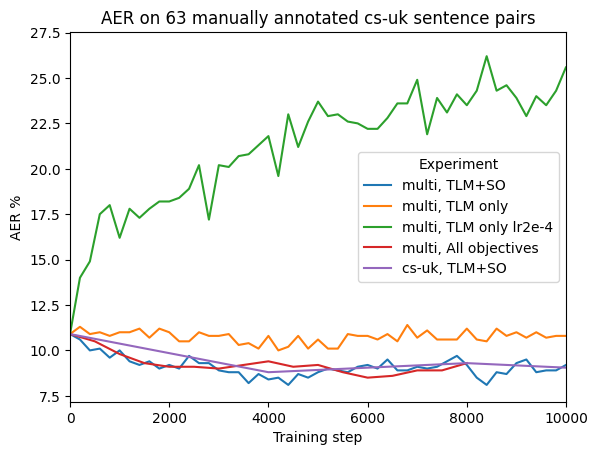

In [121]:
# plot results without any smoothing

for label, res in results.items():
    plt.plot(*zip(*res), label=label)
plt.title("AER on 63 manually annotated cs-uk sentence pairs")
plt.xlabel("Training step")
plt.ylabel("AER %")
plt.legend(title="Experiment")
plt.xlim(0,10000)

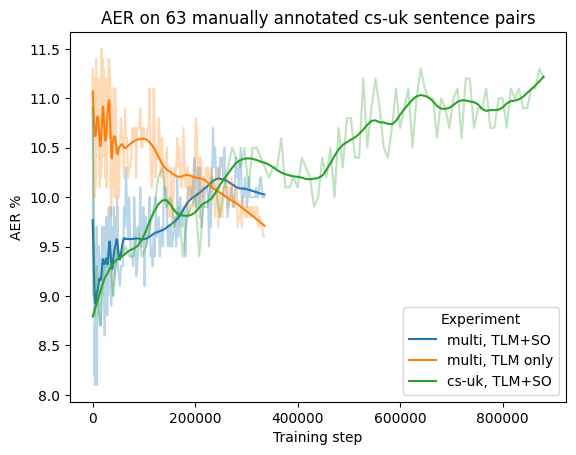

In [122]:
# plot results and smooth using LOWESS

colors = mcolors.TABLEAU_COLORS.keys()
subset = {k: results[k] for k in ("multi, TLM+SO", "multi, TLM only", "cs-uk, TLM+SO")}
for color, (label, res) in zip(colors, subset.items()):
    x, y = zip(*res)
    z = sm.nonparametric.lowess(y, x, frac=0.1)
    plt.plot(x, y, alpha=0.3, color=color)
    plt.plot(z[:,0], z[:,1], label=label, color=color)

plt.title("AER on 63 manually annotated cs-uk sentence pairs")
plt.xlabel("Training step")
plt.ylabel("AER %")
plt.legend(title="Experiment")
# plt.xlim(-5000,30000)
# plt.xscale("log")